# Burst Fitting example using BurstFit class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm
from burstfit.io import BurstIO
import logging
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

## Get candidate cutout and preprocess

We will use `BurstData` class for this. It will crop the relevant time window. Dedisperse the data. Normalise the data to zero mean and unit standard deviation. Apply RFI masks (if any) and RFI filtering (if activated). 

In [3]:
#fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil' # test data provided
fil_file = '/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_99.fil' # our data (beam 98)
#fil_file = "/home/ubuntu/gechen/fake_data/test_1beams_10s.fil"
#fil_file='/data/dsa110/T1/corr09/2021_10_8_0_29_27/fil_211009aacy/211009aacy_175.fil'


In [4]:
# example data 
# bd = BurstData(
#     fp=fil_file,
#     dm=565.3,
#     tcand=2,
#     width=64,
#     snr=11.9,
#     min_samp=256,
# )

#210920aaai
bd = BurstData(
    fp=fil_file,
    dm=56,
    tcand=0.5, # pulse starting time in s.
    width=4, # in time sample   
    snr=23.2, 
)

In [5]:
# We will mask channel numbers from 53 to 64 as they are 0. 
#bd.prepare_data(mask_chans=[(53, 64)])
#bd.prepare_data(mask_chans=[(0, 180), (900,1100)]) # ? 
bd.prepare_data(time_window=0.1) #time_window=0.2s, mask_chans=[],normalise=True

2021-10-21 20:48:36,082 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-10-21 20:48:36,100 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.1s.
2021-10-21 20:48:36,101 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-10-21 20:48:36,109 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (35.896940606901545, 21.217459086618593)


Using <class 'str'>:
/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_99.fil

In [6]:
print(0.1/bd.tsamp)
print(np.shape(bd.sgram))
print(bd.mask)

381.4697265625
(1024, 380)
[False False False ... False False False]


In [7]:
#np.set_printoptions(threshold=np.inf)
print(bd.data[200])
print(bd.sgram)

[0 0 0 ... 0 0 0]
[[-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]
 [-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]
 [-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]
 ...
 [-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]
 [-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]
 [-1.6918586492538452 -1.6918586492538452 -1.6918586492538452 ...
  -1.6918586492538452 -1.6918586492538452 -1.6918586492538452]]


In [8]:
print(np.shape(bd.data))
print(4./bd.tsamp/4)
print(np.shape(bd.sgram))
print(0.1/bd.tsamp)

(512, 1024)
3814.6972656249995
(1024, 380)
381.4697265625


Here is the burst

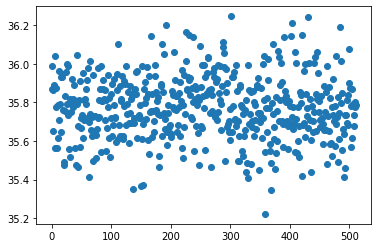

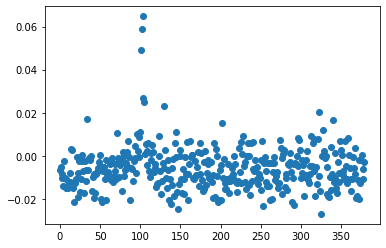

In [9]:
plt.scatter(range(len(bd.data.mean(1))), bd.data.mean(1))
plt.figure()
plt.scatter(range(len(bd.sgram.mean(0))), bd.sgram.mean(0))

In [10]:
bd.sgram.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

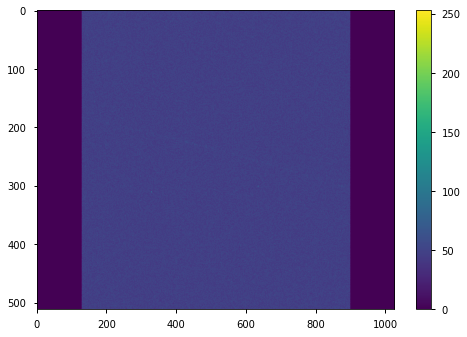

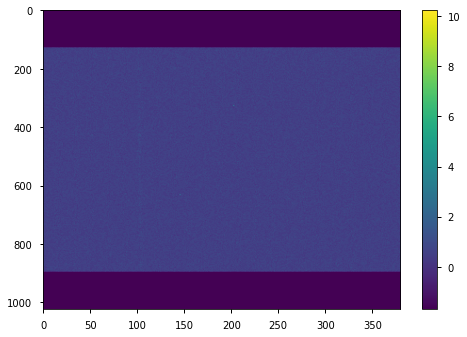

In [11]:
plot_me(bd.data)
plot_me(bd.sgram)

In [12]:
# For the plotter eror: 
# choose an available style from below:
# plt.style.available
# change burstfit/utils/plotter.py to use this style
# re-install: python setup.py install


## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [13]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/ubuntu/proj/dsa110-shell/dsa110-T3/dsaT3/')
sys.path.insert(1, '/home/ubuntu/gechen/software')

import filplot_funcs as ff

/home/ubuntu/gechen/software/filplot_funcs.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes
2021-10-21 20:48:37,262 - _logit -dsaStore - INFO - {"mjd": 59508.867097938644, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-10-21T20:48:37.261890Z", "msg": "TODO: implement"}
2021-10-21 20:48:37,264 - _logit -dsaStore - INFO - {"mjd": 59508.86709795796, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-10-21T20:48:37.263550Z", "msg": "TODO: implement"}
2021-10-21 20:48:37,266 - _logit -dsaStore - INFO - {"mjd": 59508.86709798653, "proj": "

Secrets not found. Cannot use datacite API


2021-10-21 20:48:37,929 - _logit -dsaStore - INFO - {"mjd": 59508.86710565757, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-10-21T20:48:37.928796Z", "msg": "TODO: implement"}
2021-10-21 20:48:37,932 - _logit -dsaStore - INFO - {"mjd": 59508.86710569687, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-10-21T20:48:37.932189Z", "msg": "TODO: implement"}
2021-10-21 20:48:37,936 - _logit -dsaStore - INFO - {"mjd": 59508.8671057369, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2021-10-21T20:48:37.935650Z", "msg": "DsaStore created"}
2021-10-21 20:48:37,942 - _logit -Conf - INFO - {"mjd": 59508.86710580426, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "Conf", "function": "_check

In [42]:
data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=256) 

(256, 15258)
15258.789062499998


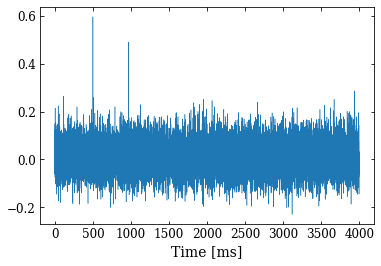

In [43]:
plt.plot(np.array([i*bd.tsamp*1e3 for i in range(len(data.mean(0)))]), data.mean(0))
plt.xlabel('Time [ms]')

print(np.shape(data))
print(4./bd.tsamp) # /bd.width 4s per gulp, rebinned by the pulse width 

Text(0.5, 0, 'Channels (binned)')

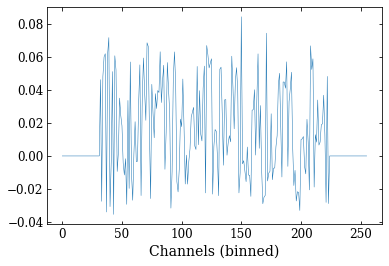

In [44]:
plt.plot(data.mean(1))
plt.xlabel('Channels (binned)')

In [45]:
# For pulse, we will use a gaussian convolved with an exponential model 
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

### Use data near the burst for fittings

In [59]:
data_burst = data[:, 0 : int(1./bd.tsamp)] 
#data_burst = data[:, int(0.45/bd.tsamp) : int(0.55/bd.tsamp)] 
sgram_mask = np.full(np.shape(data_burst), False)

np.shape(data_burst)

(256, 3814)

In [60]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)

Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [61]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, #bd.sgram not working 
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask 
)

In [62]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

2021-10-21 21:03:12,240 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-21 21:03:12,428 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-10-21 21:03:12,429 - initial_profilefit -burstfit.fit - INFO - S: 170.6924789737659 +- 4456.014224708592
2021-10-21 21:03:12,430 - initial_profilefit -burstfit.fit - INFO - mu_t: 2023.628338616281 +- 928.4955024361841
2021-10-21 21:03:12,431 - initial_profilefit -burstfit.fit - INFO - sigma_t: 0.1628806378821255 +- 406.15654781919244
2021-10-21 21:03:12,431 - initial_profilefit -burstfit.fit - INFO - tau: 35.5333682231708 +- 61.924873366537


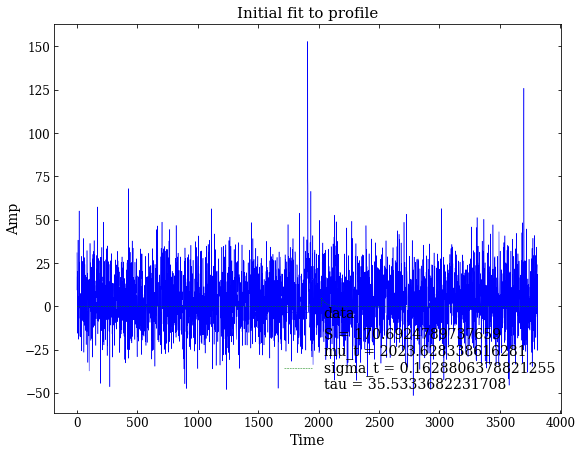

381.4697265625

In [63]:
plot = True
profile_bounds=((0, int(0.45/bd.tsamp), 0, 0), (np.inf, int(0.55/bd.tsamp), np.inf, np.inf)) # did not work when only set up bounds but do not chop data 
#profile_bounds=[]
bf.initial_profilefit(plot=plot, bounds=profile_bounds)
0.1/bd.tsamp

### Spectra Fit

In [23]:
bf.make_spectra()

2021-10-21 20:49:09,577 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.


2021-10-21 20:49:09,588 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-21 20:49:09,600 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-21 20:49:09,602 - initial_spectrafit -burstfit.fit - INFO - mu_f: 147.95320909056176 +- 32.530396523888726
2021-10-21 20:49:09,603 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 55.208227303565934 +- 27.02987507456114


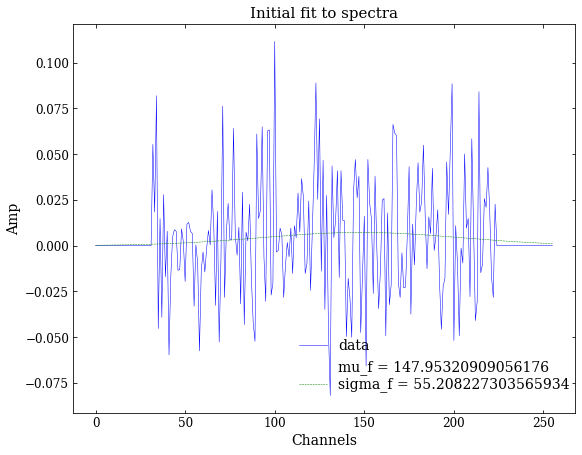

In [24]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [25]:
bf.profile_params

{1: {'popt': [170.6924789737659,
   2023.628338616281,
   0.1628806378821255,
   35.5333682231708],
  'perr': array([4456.01422471,  928.49550244,  406.15654782,   61.92487337])}}

In [26]:
bf.spectra_params

{1: {'popt': [147.95320909056176, 55.208227303565934],
  'perr': array([32.53039652, 27.02987507])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

2021-10-21 20:49:09,806 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-21 20:49:09,807 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [147.95320909056176, 55.208227303565934, 170.6924789737659, 2023.628338616281, 0.1628806378821255, 35.5333682231708, 56]
2021-10-21 20:49:19,524 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-21 20:49:19,525 - sgram_fit -burstfit.fit - INFO - mu_f: 116.21909146758578 +- 6722.406781030032
2021-10-21 20:49:19,526 - sgram_fit -burstfit.fit - INFO - sigma_f: 66.96125133151988 +- 87.95603918460196
2021-10-21 20:49:19,527 - sgram_fit -burstfit.fit - INFO - S: 490706.5763294721 +- 614964191.3498538
2021-10-21 20:49:19,528 - sgram_fit -burstfit.fit - INFO - mu_t: 3218.919849247693 +- 86804748.0111875
2021-10-21 20:49:19,528 - sgram_fit -burstfit.fit - INFO - sigma_t: 31937.267378420627 +- 21580159.89422869
2021-10-21 20:49:19,529 - sgram_fit -burstfit.fit - INFO - tau: 19770.019343

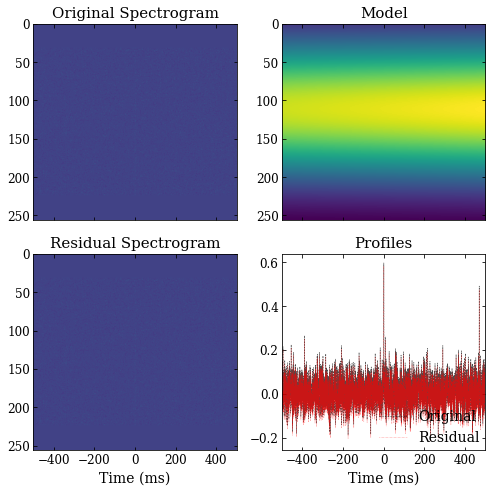

2021-10-21 20:49:20,314 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:20,315 - model -burstfit.fit - INFO - Found 1 components.


In [27]:
bf.sgram_fit(plot=plot)

We can see the reduced chi square value of our sgram_fit too

In [28]:
bf.calc_redchisq()

2021-10-21 20:49:20,392 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:20,393 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
2021-10-21 20:49:20,398 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:20,399 - model -burstfit.fit - INFO - Found 1 components.
2021-10-21 20:49:20,517 - calc_redchisq -b

masked

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [29]:
bf.sgram_params

{1: {'popt': [116.21909146758578,
   66.96125133151988,
   490706.5763294721,
   3218.919849247693,
   31937.267378420627,
   19770.01934339159,
   20802.47855585724],
  'perr': array([6.72240678e+03, 8.79560392e+01, 6.14964191e+08, 8.68047480e+07,
         2.15801599e+07, 1.66641763e+08, 2.89905062e+06])}}

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

2021-10-21 20:49:20,538 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-10-21 20:49:20,541 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-21 20:49:20,597 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-10-21 20:49:20,598 - initial_profilefit -burstfit.fit - INFO - S: 738.3029275899924 +- 61.93311019978991
2021-10-21 20:49:20,599 - initial_profilefit -burstfit.fit - INFO - mu_t: 1907.9128806480696 +- 0.2772049184392725
2021-10-21 20:49:20,599 - initial_profilefit -burstfit.fit - INFO - sigma_t: 1.2342150319446634 +- 0.266797301130302
2021-10-21 20:49:20,601 - initial_profilefit -burstfit.fit - INFO - tau: 2.2733772907256746 +- 0.5985733380866283


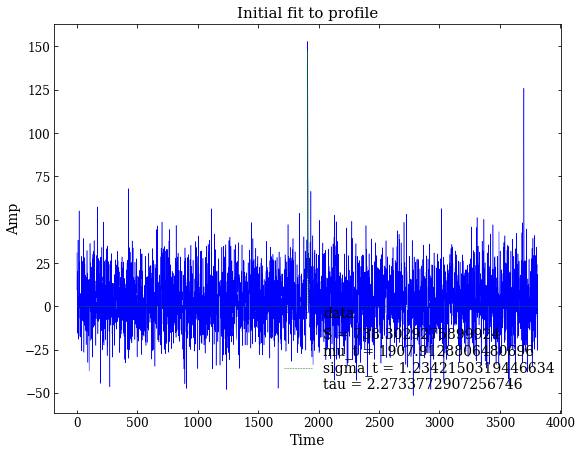

2021-10-21 20:49:20,918 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-21 20:49:20,920 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-21 20:49:20,925 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-21 20:49:20,926 - initial_spectrafit -burstfit.fit - INFO - mu_f: 117.17875405023754 +- 5.867230192422801
2021-10-21 20:49:20,927 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 52.50577892536739 +- 4.843528303019002


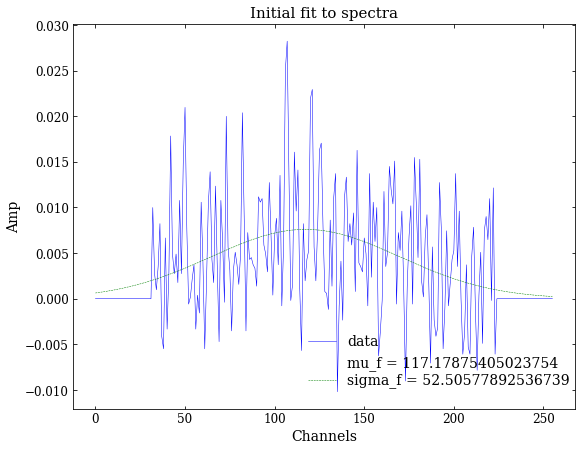

2021-10-21 20:49:21,249 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-21 20:49:21,250 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [117.17875405023754, 52.50577892536739, 738.3029275899924, 1907.9128806480696, 1.2342150319446634, 2.2733772907256746, 56]
2021-10-21 20:49:23,501 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-21 20:49:23,502 - sgram_fit -burstfit.fit - INFO - mu_f: 128.60950719769284 +- 4.321643779886977
2021-10-21 20:49:23,503 - sgram_fit -burstfit.fit - INFO - sigma_f: 61.89027732549449 +- 4.623028332335949
2021-10-21 20:49:23,503 - sgram_fit -burstfit.fit - INFO - S: 724.2691721783907 +- 55.33001125427281
2021-10-21 20:49:23,505 - sgram_fit -burstfit.fit - INFO - mu_t: 1906.283892515681 +- 0.28968049637883436
2021-10-21 20:49:23,506 - sgram_fit -burstfit.fit - INFO - sigma_t: 0.7868370237362919 +- 0.1411612005788221
2021-10-21 20:49:23,507 - sgram_fit -burstfit.fit - INFO - tau: 1.6866

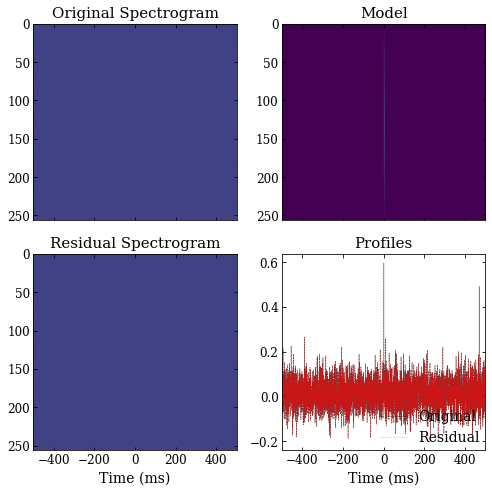

2021-10-21 20:49:24,262 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:24,263 - model -burstfit.fit - INFO - Found 1 components.
2021-10-21 20:49:24,313 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:24,314 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-21 20:49:24,317 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:24,317 - model -burstfit.fit - INFO - Found 1 components.
2021-10-21 20:49:24,401 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0064673420392407


In [30]:
bf.fitcycle(plot=True) #profile_bounds=[450, 550]

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-10-21 20:49:24,407 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-21 20:49:24,408 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-21 20:49:24,413 - tests -root - INFO - P values: T-test (0.82125), Kruskal (0.94906), KS (0.85176), F-test (0.22695)
2021-10-21 20:49:24,414 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-10-21 20:49:24,420 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2021-10-21 20:49:24,420 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-10-21 20:49:24,426 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00001), F-test (0.00002)
2021-10-21 20:49:24,427 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-10-21 20:49:24,429 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-21 20:49:24,483 - initial_profilefi

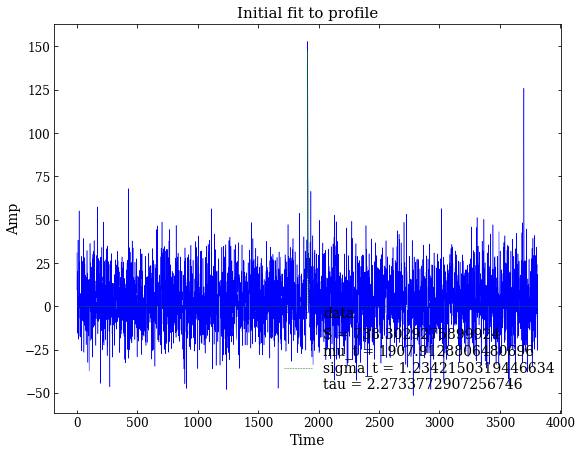

2021-10-21 20:49:24,748 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-21 20:49:24,750 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-21 20:49:24,756 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-21 20:49:24,756 - initial_spectrafit -burstfit.fit - INFO - mu_f: 117.17875405023754 +- 5.867230192422801
2021-10-21 20:49:24,757 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 52.50577892536739 +- 4.843528303019002


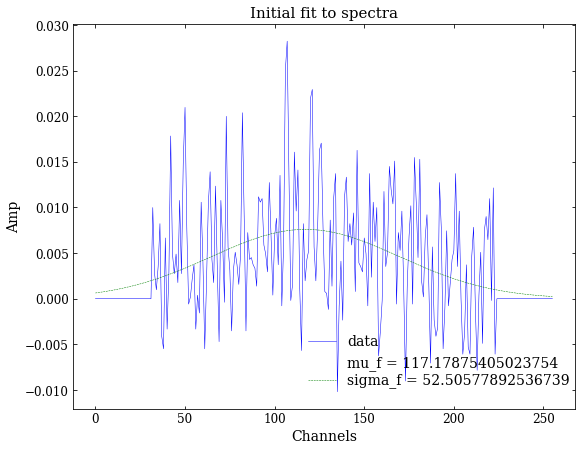

2021-10-21 20:49:24,942 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-21 20:49:24,943 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [117.17875405023754, 52.50577892536739, 738.3029275899924, 1907.9128806480696, 1.2342150319446634, 2.2733772907256746, 56]
2021-10-21 20:49:27,491 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-21 20:49:27,492 - sgram_fit -burstfit.fit - INFO - mu_f: 128.60950719769284 +- 4.321643779886977
2021-10-21 20:49:27,493 - sgram_fit -burstfit.fit - INFO - sigma_f: 61.89027732549449 +- 4.623028332335949
2021-10-21 20:49:27,494 - sgram_fit -burstfit.fit - INFO - S: 724.2691721783907 +- 55.33001125427281
2021-10-21 20:49:27,494 - sgram_fit -burstfit.fit - INFO - mu_t: 1906.283892515681 +- 0.28968049637883436
2021-10-21 20:49:27,495 - sgram_fit -burstfit.fit - INFO - sigma_t: 0.7868370237362919 +- 0.1411612005788221
2021-10-21 20:49:27,497 - sgram_fit -burstfit.fit - INFO - tau: 1.6866

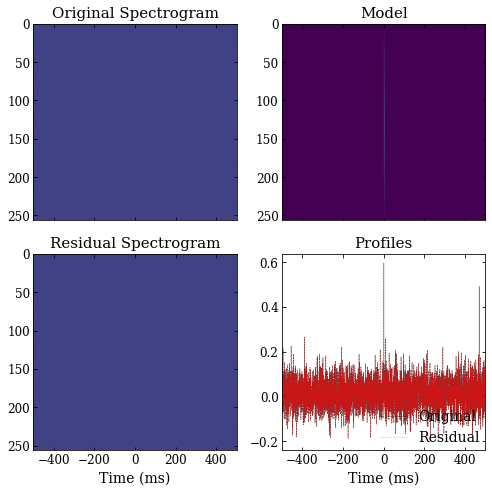

2021-10-21 20:49:28,249 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:28,251 - model -burstfit.fit - INFO - Found 1 components.
2021-10-21 20:49:28,304 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:28,305 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-21 20:49:28,307 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:28,308 - model -burstfit.fit - INFO - Found 1 components.
2021-10-21 20:49:28,398 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0064673420392407
2021-10-21 20:49:28,399 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-21 20:49:28,400 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-21 20:49:28,404 - tests -root - INFO - P values: T-test (0.82125), Kruskal (0.94906), KS (0.85176), F-test (0.22695)
2021-10-21 20:49:28,405 - run

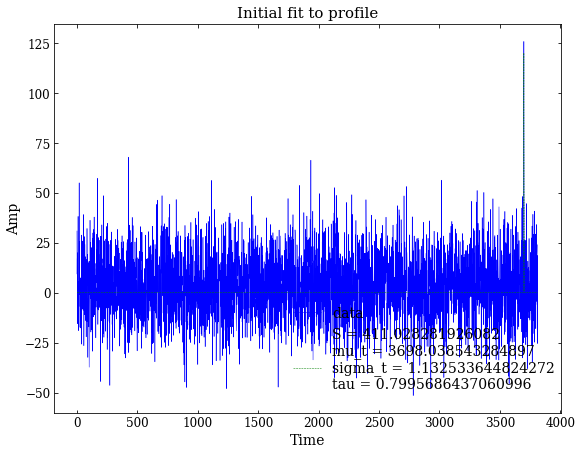

2021-10-21 20:49:28,749 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-21 20:49:28,751 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2
2021-10-21 20:49:28,756 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-21 20:49:28,756 - initial_spectrafit -burstfit.fit - INFO - mu_f: 116.23225211239584 +- 7.613534586348701
2021-10-21 20:49:28,756 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 51.829386926583034 +- 6.280722048335213


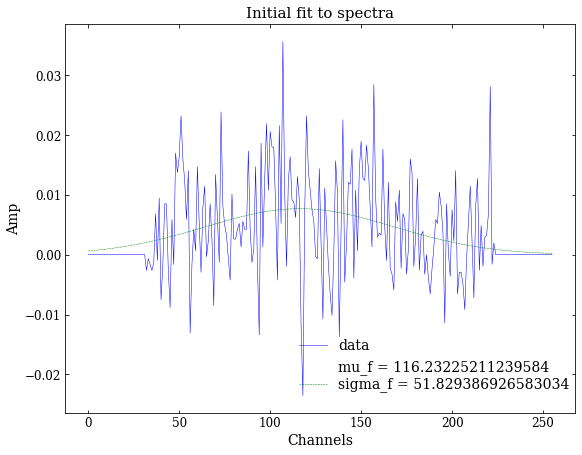

2021-10-21 20:49:28,921 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2021-10-21 20:49:28,922 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [116.23225211239584, 51.829386926583034, 411.028281926082, 3698.038543284897, 1.132533644824272, 0.7995686437060996, 56]
2021-10-21 20:49:31,826 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-21 20:49:31,827 - sgram_fit -burstfit.fit - INFO - mu_f: 130.31628275340125 +- 5.701996133533717
2021-10-21 20:49:31,828 - sgram_fit -burstfit.fit - INFO - sigma_f: 62.122657698676264 +- 6.099364021307845
2021-10-21 20:49:31,828 - sgram_fit -burstfit.fit - INFO - S: 421.0165237333373 +- 42.05759761330688
2021-10-21 20:49:31,829 - sgram_fit -burstfit.fit - INFO - mu_t: 3696.1904180432684 +- 0.23904089486350763
2021-10-21 20:49:31,829 - sgram_fit -burstfit.fit - INFO - sigma_t: 0.5156110427768761 +- 0.11551534303231659
2021-10-21 20:49:31,830 - sgram_fit -burstfit.fit - INFO - tau: 0.912

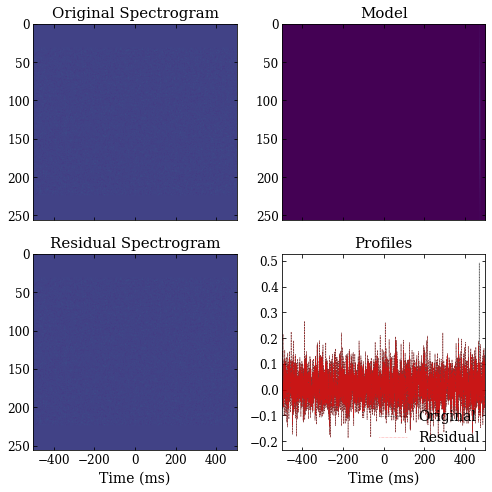

2021-10-21 20:49:32,605 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:32,606 - model -burstfit.fit - INFO - Found 2 components.
2021-10-21 20:49:32,703 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:32,704 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-21 20:49:32,707 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:32,708 - model -burstfit.fit - INFO - Found 2 components.
2021-10-21 20:49:32,837 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.006222543235503
2021-10-21 20:49:32,838 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-21 20:49:32,839 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-21 20:49:32,848 - tests -root - INFO - P values: T-test (0.82125), Kruskal (0.94906), KS (0.85176), F-test (0.22695)
2021-10-21 20:49:32,849 - run_

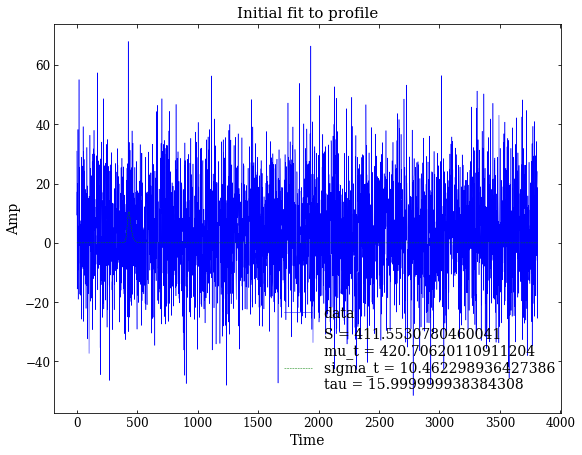

2021-10-21 20:49:33,188 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-21 20:49:33,189 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 3
2021-10-21 20:49:33,194 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-21 20:49:33,194 - initial_spectrafit -burstfit.fit - INFO - mu_f: 124.43585514267308 +- 22.03966564618367
2021-10-21 20:49:33,195 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 56.35288295421629 +- 18.287444196098644


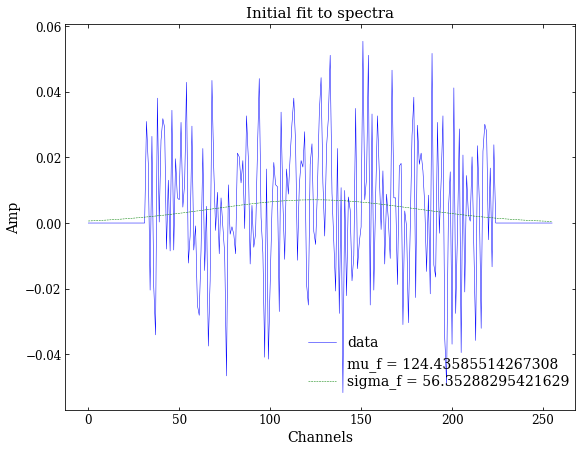

2021-10-21 20:49:33,361 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 3
2021-10-21 20:49:33,362 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [124.43585514267308, 56.35288295421629, 411.5530780460041, 420.70620110911204, 10.462298936427386, 15.999999938384308, 56]
2021-10-21 20:49:40,007 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-21 20:49:40,009 - sgram_fit -burstfit.fit - INFO - mu_f: 123.98681217874588 +- 18.149321032238344
2021-10-21 20:49:40,010 - sgram_fit -burstfit.fit - INFO - sigma_f: 51.55401023579373 +- 18.471203183203574
2021-10-21 20:49:40,012 - sgram_fit -burstfit.fit - INFO - S: 308.5993042041888 +- 104.70892868350744
2021-10-21 20:49:40,012 - sgram_fit -burstfit.fit - INFO - mu_t: 420.77271726241725 +- 7.609360780900513
2021-10-21 20:49:40,013 - sgram_fit -burstfit.fit - INFO - sigma_t: 8.778030635051897 +- 2.6967454688900134
2021-10-21 20:49:40,013 - sgram_fit -burstfit.fit - INFO - tau: 2.033

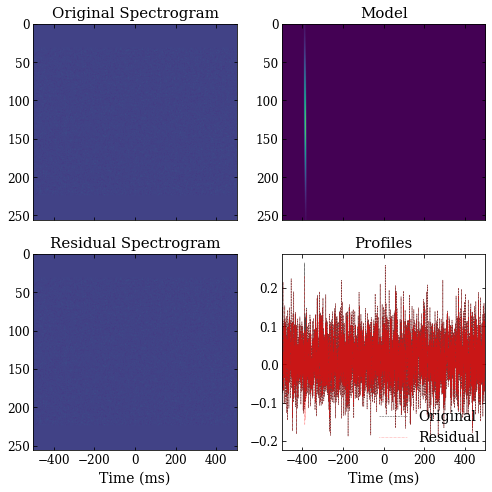

2021-10-21 20:49:40,789 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:40,790 - model -burstfit.fit - INFO - Found 3 components.
2021-10-21 20:49:40,928 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:40,929 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-21 20:49:40,931 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:40,931 - model -burstfit.fit - INFO - Found 3 components.
2021-10-21 20:49:41,111 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0028437979222018
2021-10-21 20:49:41,112 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-21 20:49:41,113 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-21 20:49:41,118 - tests -root - INFO - P values: T-test (0.82125), Kruskal (0.94906), KS (0.85176), F-test (0.22695)
2021-10-21 20:49:41,119 - run

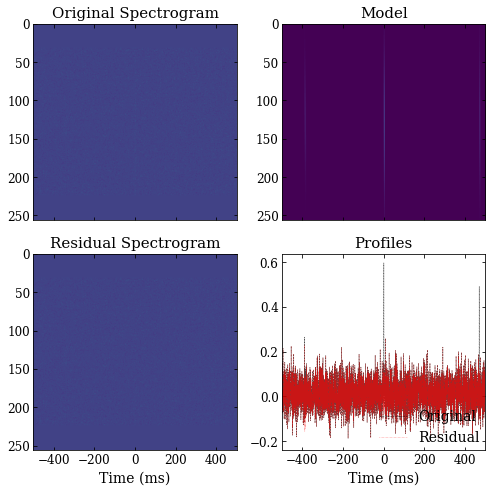

2021-10-21 20:49:47,529 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:47,530 - model -burstfit.fit - INFO - Found 3 components.
2021-10-21 20:49:47,666 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-21 20:49:47,667 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2021-10-21 20:49:47,669 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:47,669 - model -burstfit.fit - INFO - Found 3 components.
2021-10-21 20:49:47,849 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0028437979222018
2021-10-21 20:49:47,850 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-21 20:49:47,851 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-21 20:49:47,855 - tests -root - INFO - P values: T-test (0.82125), Kruskal (0.94906), KS (0.85176), F-test (0.22695)
2021-10-21 20:4

In [31]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [32]:
bf.sgram_params['all']

{1: {'popt': [128.60950719769284,
   61.89027732549449,
   724.2691721783907,
   1906.283892515681,
   0.7868370237362919,
   1.68668677826595,
   62.53927220223662],
  'perr': array([ 4.32217766,  4.62416162, 55.22878386,  0.28645371,  0.13953438,
          0.29732979,  0.89590066])},
 2: {'popt': [130.31628275340125,
   62.122657698676264,
   421.0165237333373,
   3696.1904180432684,
   0.5156110427768761,
   0.912465800331985,
   62.36962594628715],
  'perr': array([ 5.72022069,  6.12585276, 42.13015335,  0.23769707,  0.11506722,
          0.23870097,  0.72099376])},
 3: {'popt': [123.98681217874588,
   51.55401023579373,
   308.5993042041888,
   420.77271726241725,
   8.778030635051897,
   2.0337062994242068,
   91.48045519713172],
  'perr': array([ 18.14945115,  18.47133561, 104.70967939,   7.60941534,
           2.6967648 ,   0.37039158,  25.41952819])}}

## Plotting Results 

We can also plot the model, sgram and residuals

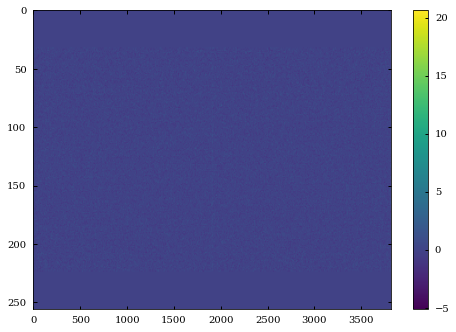

In [33]:
plot_me(bf.sgram)

2021-10-21 20:49:48,389 - model -burstfit.fit - INFO - Making model.
2021-10-21 20:49:48,390 - model -burstfit.fit - INFO - Found 3 components.


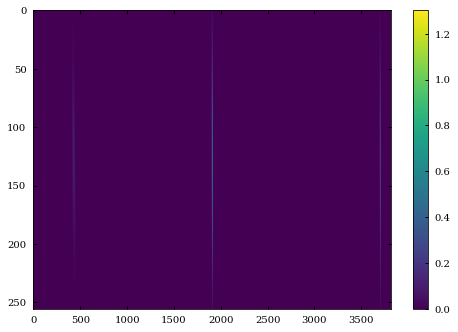

In [34]:
plot_me(bf.model)

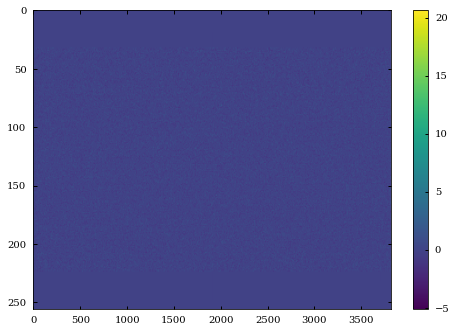

In [35]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [36]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

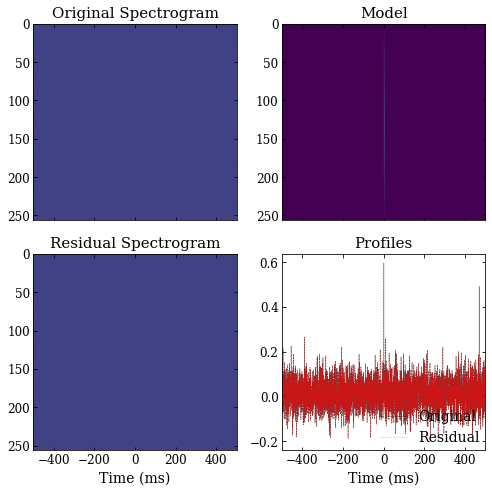

In [37]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

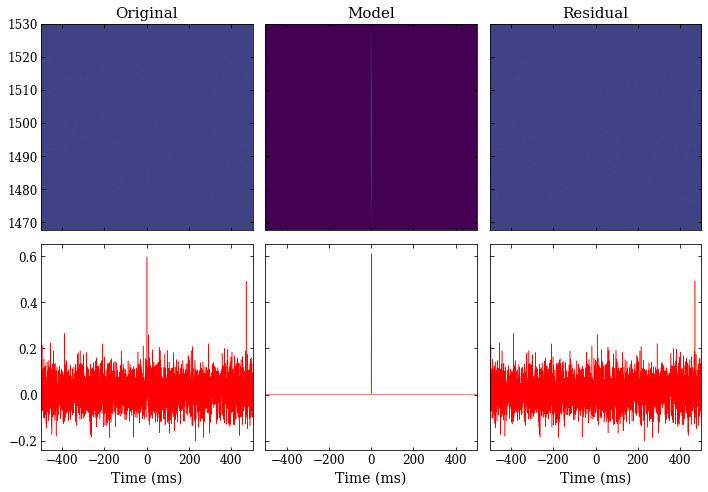

In [38]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

In [39]:
bf.profile_params

{1: {'popt': [738.3029275899924,
   1907.9128806480696,
   1.2342150319446634,
   2.2733772907256746],
  'perr': array([61.9331102 ,  0.27720492,  0.2667973 ,  0.59857334])},
 2: {'popt': [411.028281926082,
   3698.038543284897,
   1.132533644824272,
   0.7995686437060996],
  'perr': array([46.00066191,  0.58222966,  0.33243266,  0.82286506])},
 3: {'popt': [411.5530780460041,
   420.70620110911204,
   10.462298936427386,
   15.999999938384308],
  'perr': array([167.27020294,  11.98787538,  10.68938902,  23.71375156])}}

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  